# California Housing Price Prediction using OLS

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

california_housing = fetch_california_housing(as_frame=True) 
df = california_housing.frame


In [51]:
df.info()
df.describe().T
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Removing Capped Values

When I explored the California Housing dataset, I noticed that many house values were **capped at 5.0** (meaning $500,000).  
This cap caused a flat line at the top of the scatter plot.  
After filtering out rows where `MedHouseVal >= 5.0`, the relationship between **income** and **house value** looked much clearer.


Removed observations: 27 (0.13%)


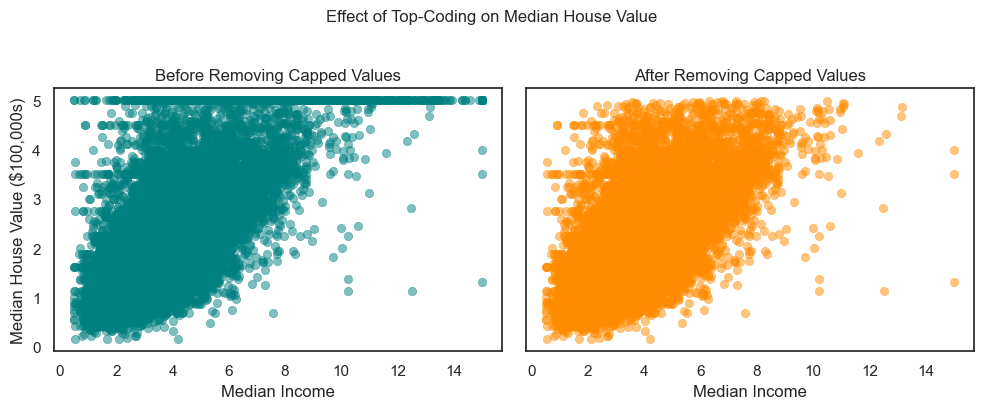

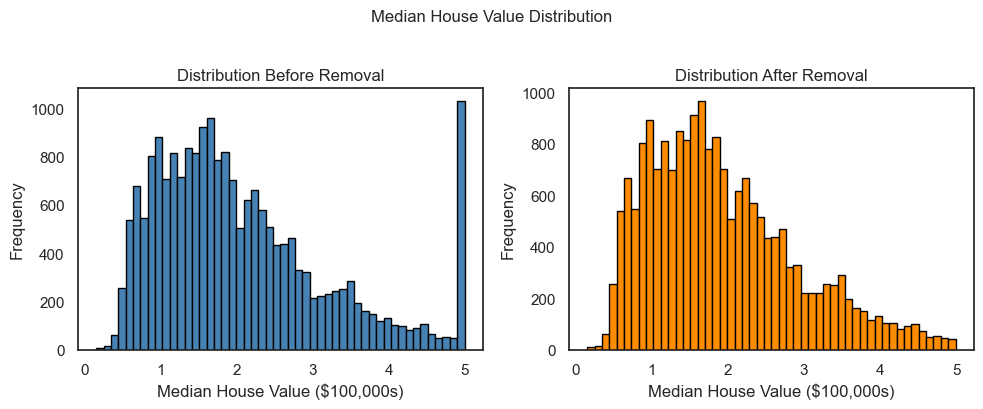

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_full = df.copy()
removed = (df_full["MedHouseVal"] == 5.0).sum()
print(f"Removed observations: {removed} ({removed/len(df_full)*100:.2f}%)")

df_trim = df_full[df_full["MedHouseVal"] < 5.0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.scatterplot(
    x="MedInc", y="MedHouseVal", data=df_full,
    alpha=0.5, color="teal", ax=axes[0], edgecolor=None
)
axes[0].set_title("Before Removing Capped Values")
axes[0].set_xlabel("Median Income")
axes[0].set_ylabel("Median House Value ($100,000s)")

sns.scatterplot(
    x="MedInc", y="MedHouseVal", data=df_trim,
    alpha=0.5, color="darkorange", ax=axes[1], edgecolor=None
)
axes[1].set_title("After Removing Capped Values")
axes[1].set_xlabel("Median Income")
axes[1].set_ylabel("")

plt.suptitle("Effect of Top-Coding on Median House Value", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(df_full["MedHouseVal"], bins=50, color="steelblue", edgecolor="black")
axes[0].set_title("Distribution Before Removal")
axes[0].set_xlabel("Median House Value ($100,000s)")
axes[0].set_ylabel("Frequency")

axes[1].hist(df_trim["MedHouseVal"], bins=50, color="darkorange", edgecolor="black")
axes[1].set_title("Distribution After Removal")
axes[1].set_xlabel("Median House Value ($100,000s)")
axes[1].set_ylabel("Frequency")

plt.suptitle("Median House Value Distribution", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

### Exploring Target Transformations

One of the assumptions of OLS is that the model errors are normally distributed.  
When the target variable is heavily skewed, this assumption is often violated because the residuals inherit that skew.  
Transforming the target (for example with a log or square root) doesn’t change the underlying relationships but can make the residuals more symmetric and closer to normality.  
This step isn’t mandatory, but it can improve model stability and make inference from OLS more reliable.


                     Mean    Std  Skewness  Kurtosis
MedHouseVal         1.921  0.971     0.795     0.122
Log1p(MedHouseVal)  1.019  0.323     0.139    -0.654
Sqrt(MedHouseVal)   1.342  0.346     0.273    -0.517


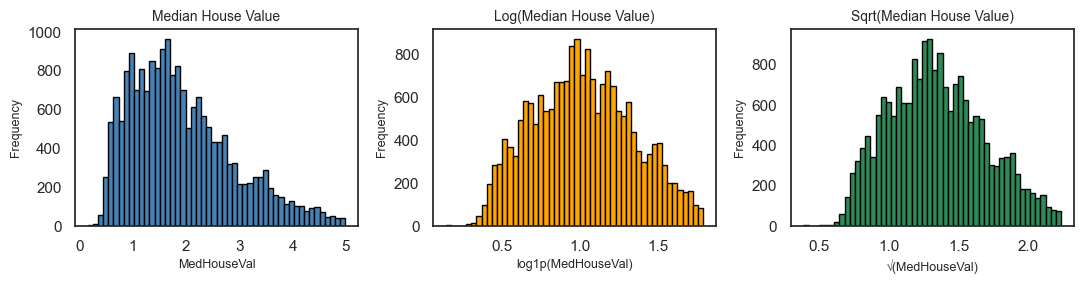

In [53]:
df = df_trim.copy()
target = df["MedHouseVal"]

target_log = np.log1p(target)
target_sqrt = np.sqrt(target)

summary = pd.DataFrame({
    "Mean": [target.mean(), target_log.mean(), target_sqrt.mean()],
    "Std": [target.std(), target_log.std(), target_sqrt.std()],
    "Skewness": [target.skew(), target_log.skew(), target_sqrt.skew()],
    "Kurtosis": [target.kurtosis(), target_log.kurtosis(), target_sqrt.kurtosis()]
}, index=["MedHouseVal", "Log1p(MedHouseVal)", "Sqrt(MedHouseVal)"])

print(summary.round(3))

fig, axes = plt.subplots(1, 3, figsize=(11, 3))

axes[0].hist(target, bins=50, edgecolor="black", color="steelblue")
axes[0].set_title("Median House Value", fontsize=10)
axes[0].set_xlabel("MedHouseVal", fontsize=9)
axes[0].set_ylabel("Frequency", fontsize=9)

axes[1].hist(target_log, bins=50, edgecolor="black", color="orange")
axes[1].set_title("Log(Median House Value)", fontsize=10)
axes[1].set_xlabel("log1p(MedHouseVal)", fontsize=9)
axes[1].set_ylabel("Frequency", fontsize=9)

axes[2].hist(target_sqrt, bins=50, edgecolor="black", color="seagreen")
axes[2].set_title("Sqrt(Median House Value)", fontsize=10)
axes[2].set_xlabel("√(MedHouseVal)", fontsize=9)
axes[2].set_ylabel("Frequency", fontsize=9)

plt.tight_layout()
plt.show()

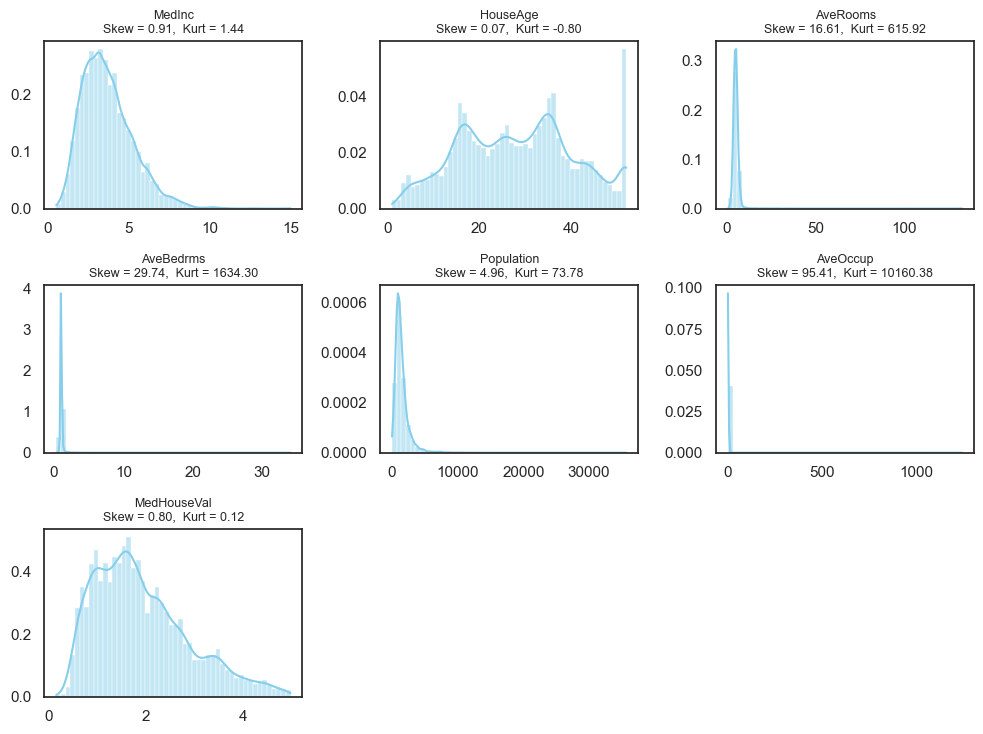

In [54]:
cols = [c for c in df.columns if c not in ["Latitude", "Longitude"]]

stats = pd.DataFrame({
    "skew": df[cols].skew(),
    "kurtosis": df[cols].kurtosis()
})

n_cols = 3
n_rows = int(np.ceil(len(cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2.5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color="skyblue", stat="density")
    axes[i].set_title(
        f"{col}\nSkew = {stats.loc[col, 'skew']:.2f},  Kurt = {stats.loc[col, 'kurtosis']:.2f}",
        fontsize=9
    )
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Applying Log Transformations to Skewed Features

Several features, such as **median income**, **average rooms**, and **population**, are strongly right-skewed — most values are low, with a few extremely high ones.  
This imbalance can make linear regression less stable and weaken the linear relationship with the target.

To address this, I created a copy of the DataFrame and applied **logarithmic transformations** to these skewed variables.  
For `MedInc`, I used `np.log()` since it contains only positive values.  
For the others (`AveRooms`, `AveBedrms`, `AveOccup`, `Population`), I used `np.log1p()` to safely include zeros.  

These transformations compress large values, reduce skewness, and make the features behave more linearly with respect to the target, which improves model performance and interpretability.


In [55]:
df_transformed = df.copy()

df_transformed['MedInc'] = np.log(df['MedInc'])
df_transformed['AveRooms'] = np.log1p(df['AveRooms'])
df_transformed['AveBedrms'] = np.log1p(df['AveBedrms'])
df_transformed['AveOccup'] = np.log1p(df['AveOccup'])
df_transformed['Population'] = np.log1p(df['Population'])
df_transformed['MedHouseVal'] = np.log(df['MedHouseVal'])

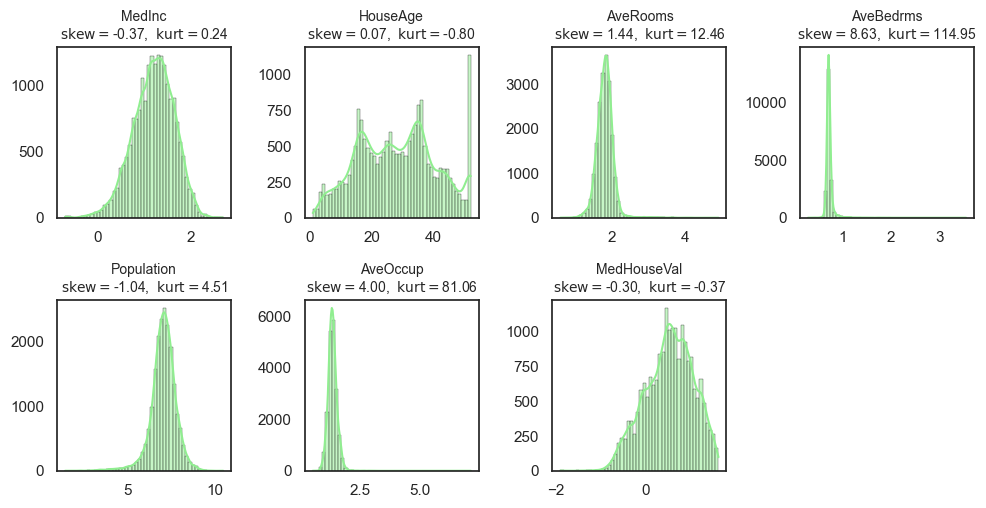

In [56]:
cols = [c for c in df_transformed.columns if c not in ["Latitude", "Longitude"]]

stats_trans = pd.DataFrame({
    'skew': df_transformed[cols].skew(),
    'kurtosis': df_transformed[cols].kurtosis()
})

n_rows_trans = 3  
fig, axes = plt.subplots(n_rows_trans, 4, figsize=(10, 2.5 * n_rows_trans))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df_transformed[col], bins=50, kde=True, ax=axes[i],
                 color='lightgreen', edgecolor='black')
    axes[i].set_title(
        f"{col}\n"
        r"$\text{skew} = $" + f"{stats_trans.loc[col, 'skew']:.2f},  "
        r"$\text{kurt} = $" + f"{stats_trans.loc[col, 'kurtosis']:.2f}",
        fontsize=10
    )
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


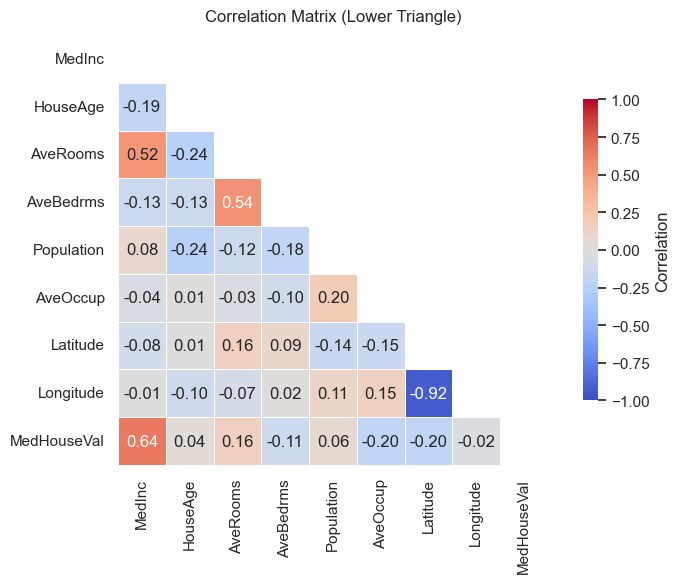

Highly correlated feature pairs (|r| > 0.8):


,Feature1,Feature2,Correlation
27,Longitude,Latitude,-0.924139



VARIANCE INFLATION FACTOR (VIF) ANALYSIS

VIF for Predictor Features:
VIF > 10 indicates high multicollinearity


,Feature,VIF
0,const,18704.472053
7,Latitude,9.933815
8,Longitude,9.388025
3,AveRooms,3.414518
1,MedInc,2.571077
4,AveBedrms,2.163381
2,HouseAge,1.255967
5,Population,1.196399
6,AveOccup,1.091100



Features with VIF > 10: 0
No severe multicollinearity detected (all VIF < 10)

VIF Interpretation Guide:
VIF = 1: No correlation
1 < VIF < 5: Moderate correlation
5 < VIF < 10: High correlation
VIF > 10: Severe multicollinearity


In [57]:
corr = df_transformed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 6))
sns.set_theme(style="white")
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",     
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=.4,
    cbar_kws={"shrink": .7, "label": "Correlation"}
)
plt.title("Correlation Matrix (Lower Triangle)", fontsize=12, pad=10)
plt.tight_layout()
plt.show()

threshold = 0.8
corr_pairs = (
    corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr = corr_pairs[abs(corr_pairs['Correlation']) > threshold]

print("Highly correlated feature pairs (|r| > 0.8):")
display(high_corr)

print("\n" + "="*60)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("="*60)

predictor_features = df_transformed.drop(columns=['MedHouseVal'])
features_with_constant = sm.add_constant(predictor_features)

vif_data = pd.DataFrame()
vif_data["Feature"] = features_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(features_with_constant.values, i) 
                   for i in range(features_with_constant.shape[1])]

print("\nVIF for Predictor Features:")
print("VIF > 10 indicates high multicollinearity")
display(vif_data.sort_values("VIF", ascending=False))

high_vif = vif_data[(vif_data["VIF"] > 10) & (vif_data["Feature"] != "const")]
print(f"\nFeatures with VIF > 10: {len(high_vif)}")
if len(high_vif) > 0:
    print("High multicollinearity detected in:")
    display(high_vif)
else:
    print("No severe multicollinearity detected (all VIF < 10)")

print("\nVIF Interpretation Guide:")
print("VIF = 1: No correlation")
print("1 < VIF < 5: Moderate correlation") 
print("5 < VIF < 10: High correlation")
print("VIF > 10: Severe multicollinearity")

### Evaluating the Impact of Geographic Features

Latitude and longitude often carry strong spatial information about housing prices in California, but they can also introduce collinearity or distort the model if they interact in nonlinear ways.  
To understand their individual contribution, I fit three OLS models:

1. One with both latitude and longitude  
2. One excluding longitude  
3. One excluding latitude  

I then compare their performance using **R²** and **RMSE**, and also examine the **Variance Inflation Factor (VIF)** to see how removing each geographic coordinate affects multicollinearity.  

This helps determine whether both coordinates are needed, or if one provides most of the spatial signal while the other mainly adds redundancy or noise.


In [58]:
features_geo_full = df_transformed.drop(columns=['MedHouseVal'])
target_geo_full = df_transformed['MedHouseVal']

features_train_geo, features_test_geo, target_train_geo, target_test_geo = train_test_split(
    features_geo_full, target_geo_full, test_size=0.2, random_state=1998
)

X_train_full = sm.add_constant(features_train_geo)
X_test_full = sm.add_constant(features_test_geo)

model_geo_full = sm.OLS(target_train_geo, X_train_full).fit()
predictions_geo_full = model_geo_full.predict(X_test_full)

r2_full = r2_score(target_test_geo, predictions_geo_full)
rmse_full = np.sqrt(mean_squared_error(target_test_geo, predictions_geo_full))


features_geo_no_long = df_transformed.drop(columns=['MedHouseVal', 'Longitude'])
target_geo_no_long = df_transformed['MedHouseVal']

features_train_no_long, features_test_no_long, target_train_no_long, target_test_no_long = train_test_split(
    features_geo_no_long, target_geo_no_long, test_size=0.2, random_state=1998
)

X_train_no_long = sm.add_constant(features_train_no_long)
X_test_no_long = sm.add_constant(features_test_no_long)

model_geo_no_long = sm.OLS(target_train_no_long, X_train_no_long).fit()
predictions_no_long = model_geo_no_long.predict(X_test_no_long)

r2_no_long = r2_score(target_test_no_long, predictions_no_long)
rmse_no_long = np.sqrt(mean_squared_error(target_test_no_long, predictions_no_long))


features_geo_no_lat = df_transformed.drop(columns=['MedHouseVal', 'Latitude'])
target_geo_no_lat = df_transformed['MedHouseVal']

features_train_no_lat, features_test_no_lat, target_train_no_lat, target_test_no_lat = train_test_split(
    features_geo_no_lat, target_geo_no_lat, test_size=0.2, random_state=1998
)

X_train_no_lat = sm.add_constant(features_train_no_lat)
X_test_no_lat = sm.add_constant(features_test_no_lat)

model_geo_no_lat = sm.OLS(target_train_no_lat, X_train_no_lat).fit()
predictions_no_lat = model_geo_no_lat.predict(X_test_no_lat)

r2_no_lat = r2_score(target_test_no_lat, predictions_no_lat)
rmse_no_lat = np.sqrt(mean_squared_error(target_test_no_lat, predictions_no_lat))


print("=== GEOGRAPHIC FEATURE COMPARISON ===")
print(f"Both Latitude & Longitude: R² = {r2_full:.3f}, RMSE = {rmse_full:.3f}")
print(f"Latitude Only (No Long):   R² = {r2_no_long:.3f}, RMSE = {rmse_no_long:.3f}")
print(f"Longitude Only (No Lat):   R² = {r2_no_lat:.3f}, RMSE = {rmse_no_lat:.3f}")


print("\n=== VIF COMPARISON ===")

features_geo_no_long_vif = sm.add_constant(df_transformed.drop(columns=['MedHouseVal', 'Longitude']))
vif_no_long = pd.DataFrame({
    "Feature": features_geo_no_long_vif.columns,
    "VIF": [variance_inflation_factor(features_geo_no_long_vif.values, i)
            for i in range(features_geo_no_long_vif.shape[1])]
})
print("VIF - Latitude Only:")
display(vif_no_long.sort_values("VIF", ascending=False))

features_geo_no_lat_vif = sm.add_constant(df_transformed.drop(columns=['MedHouseVal', 'Latitude']))
vif_no_lat = pd.DataFrame({
    "Feature": features_geo_no_lat_vif.columns,
    "VIF": [variance_inflation_factor(features_geo_no_lat_vif.values, i)
            for i in range(features_geo_no_lat_vif.shape[1])]
})
print("VIF - Longitude Only:")
display(vif_no_lat.sort_values("VIF", ascending=False))

best_geo_model = max([
    (r2_full, rmse_full, "Both Latitude & Longitude"),
    (r2_no_long, rmse_no_long, "Latitude Only"),
    (r2_no_lat, rmse_no_lat, "Longitude Only")
], key=lambda x: x[0])

print(f"\n=== RECOMMENDATION ===")
print(f"Best performing model: {best_geo_model[2]} "
      f"(R² = {best_geo_model[0]:.3f}, RMSE = {best_geo_model[1]:.3f})")


=== GEOGRAPHIC FEATURE COMPARISON ===
Both Latitude & Longitude: R² = 0.635, RMSE = 0.320
Latitude Only (No Long):   R² = 0.534, RMSE = 0.362
Longitude Only (No Lat):   R² = 0.521, RMSE = 0.367

=== VIF COMPARISON ===
VIF - Latitude Only:


,Feature,VIF
0,const,613.136808
3,AveRooms,3.074091
1,MedInc,2.168043
4,AveBedrms,2.150719
5,Population,1.192306
2,HouseAge,1.166033
7,Latitude,1.121684
6,AveOccup,1.090038


VIF - Longitude Only:


,Feature,VIF
0,const,4163.001508
3,AveRooms,2.920832
4,AveBedrms,2.130959
1,MedInc,2.060887
5,Population,1.189047
2,HouseAge,1.177739
6,AveOccup,1.090581
7,Longitude,1.060056



=== RECOMMENDATION ===
Best performing model: Both Latitude & Longitude (R² = 0.635, RMSE = 0.320)


##### Keeping Both Coordinates

Latitude and longitude are correlated but both are needed for best performance.

Keeping both gives significantly better results.

##### Baseline OLS

Starting model with log-transformed features. Our reference point for comparison.
- All 8 features + coordinates
- 80/20 split
- Fixed random seed


=== Exhaustive Best Subset Selection (8 predictors total) ===

Evaluating all 8 subsets of size 1...
Evaluating all 28 subsets of size 2...
Evaluating all 56 subsets of size 3...
Evaluating all 70 subsets of size 4...
Evaluating all 56 subsets of size 5...
Evaluating all 28 subsets of size 6...
Evaluating all 8 subsets of size 7...
Evaluating all 1 subsets of size 8...

Lowest CV RMSE: 0.3194 with 8 predictors.
One-SE rule threshold: 0.3234 → simplest model uses 6 predictors.

=== Final Model (6 predictors) ===
Selected predictors: ('MedInc', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude')
Left out: ['HouseAge', 'Population']

=== OLS Performance (One-SE Model) ===
R² (train): 0.638
R² (test):  0.632
RMSE (test): 0.321
MAE (test):  0.243

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638

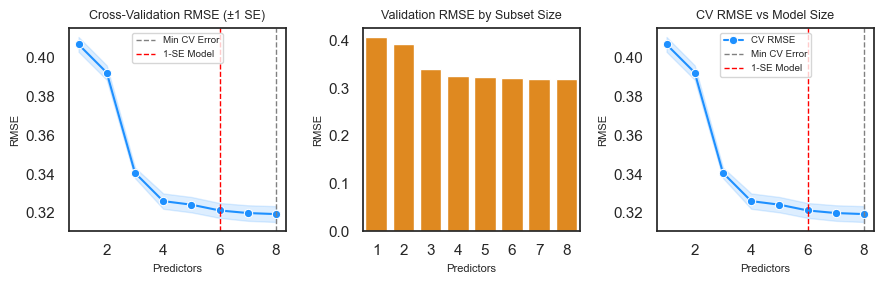

In [ ]:
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

features = df_transformed.drop(columns=['MedHouseVal'])
target = df_transformed['MedHouseVal']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=1998
)

kf = KFold(n_splits=5, shuffle=True, random_state=1998)
all_predictors = list(features_train.columns)
p = len(all_predictors)

subset_results = []

print(f"\n=== Exhaustive Best Subset Selection ({p} predictors total) ===\n")

for k in range(1, p + 1):
    print(f"Evaluating all {len(list(itertools.combinations(all_predictors, k)))} subsets of size {k}...")
    best_rmse = np.inf
    best_subset = None
    best_std = None

    for combo in itertools.combinations(all_predictors, k):
        rmse_scores = []
        for train_idx, val_idx in kf.split(features_train):
            X_train, X_val = features_train.iloc[train_idx][list(combo)], features_train.iloc[val_idx][list(combo)]
            y_train, y_val = target_train.iloc[train_idx], target_train.iloc[val_idx]
            model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
            preds = model.predict(sm.add_constant(X_val))
            rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
        avg_rmse = np.mean(rmse_scores)
        std_err = np.std(rmse_scores) / np.sqrt(kf.get_n_splits())

        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_subset = combo
            best_std = std_err

    subset_results.append((k, best_rmse, best_std, best_subset))

cv_df = pd.DataFrame(subset_results, columns=["n_predictors", "cv_rmse", "cv_se", "subset"])

best_idx = cv_df["cv_rmse"].idxmin()
best_k = int(cv_df.loc[best_idx, "n_predictors"])
best_rmse = float(cv_df.loc[best_idx, "cv_rmse"])
best_se = float(cv_df.loc[best_idx, "cv_se"])
threshold = best_rmse + best_se
one_se_candidates = cv_df[cv_df["cv_rmse"] <= threshold]
one_se_k = int(one_se_candidates["n_predictors"].min())

print(f"\nLowest CV RMSE: {best_rmse:.4f} with {best_k} predictors.")
print(f"One-SE rule threshold: {threshold:.4f} → simplest model uses {one_se_k} predictors.\n")

chosen_k = one_se_k
best_subset = cv_df.loc[cv_df["n_predictors"] == chosen_k, "subset"].iloc[0]
print(f"=== Final Model ({chosen_k} predictors) ===")
print(f"Selected predictors: {best_subset}")
print(f"Left out: {[p for p in all_predictors if p not in best_subset]}\n")

X_train_best = sm.add_constant(features_train[list(best_subset)])
X_test_best = sm.add_constant(features_test[list(best_subset)])
final_model = sm.OLS(target_train, X_train_best).fit()
preds = final_model.predict(X_test_best)

training_r2 = final_model.rsquared
testing_r2 = r2_score(target_test, preds)
testing_rmse = np.sqrt(mean_squared_error(target_test, preds))
testing_mae = mean_absolute_error(target_test, preds)

print("=== OLS Performance (One-SE Model) ===")
print(f"R² (train): {training_r2:.3f}")
print(f"R² (test):  {testing_r2:.3f}")
print(f"RMSE (test): {testing_rmse:.3f}")
print(f"MAE (test):  {testing_mae:.3f}")
print("\n" + "="*80)
print(final_model.summary())

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
sns.lineplot(x="n_predictors", y="cv_rmse", data=cv_df, marker="o", color="dodgerblue")
plt.fill_between(cv_df["n_predictors"], cv_df["cv_rmse"] - cv_df["cv_se"], cv_df["cv_rmse"] + cv_df["cv_se"], alpha=0.15, color="dodgerblue")
plt.axvline(best_k, color="gray", linestyle="--", linewidth=1, label="Min CV Error")
plt.axvline(one_se_k, color="red", linestyle="--", linewidth=1, label="1-SE Model")
plt.title("Cross-Validation RMSE (±1 SE)", fontsize=9)
plt.xlabel("Predictors", fontsize=8)
plt.ylabel("RMSE", fontsize=8)
plt.legend(fontsize=7)

plt.subplot(1, 3, 2)
sns.barplot(x="n_predictors", y="cv_rmse", data=cv_df, color="darkorange")
plt.title("Validation RMSE by Subset Size", fontsize=9)
plt.xlabel("Predictors", fontsize=8)
plt.ylabel("RMSE", fontsize=8)

plt.subplot(1, 3, 3)
sns.lineplot(x="n_predictors", y="cv_rmse", data=cv_df, label="CV RMSE", marker="o", color="dodgerblue")
plt.fill_between(cv_df["n_predictors"], cv_df["cv_rmse"] - cv_df["cv_se"], cv_df["cv_rmse"] + cv_df["cv_se"], alpha=0.15, color="dodgerblue")
plt.axvline(best_k, color="gray", linestyle="--", linewidth=1, label="Min CV Error")
plt.axvline(one_se_k, color="red", linestyle="--", linewidth=1, label="1-SE Model")
plt.title("CV RMSE vs Model Size", fontsize=9)
plt.xlabel("Predictors", fontsize=8)
plt.ylabel("RMSE", fontsize=8)
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

fitted_values = final_model.fittedvalues
model_residuals = final_model.resid
lowess_smooth = sm.nonparametric.lowess(model_residuals, fitted_values, frac=0.3)

bin_edges = np.linspace(fitted_values.min(), fitted_values.max(), 50)
bin_indices = np.digitize(fitted_values, bin_edges)
quantile_05, quantile_95, bin_centers = [], [], []
for bin_index in range(1, len(bin_edges)):
    bin_mask = bin_indices == bin_index
    if bin_mask.sum() > 10:
        quantile_05.append(np.quantile(model_residuals[bin_mask], 0.05))
        quantile_95.append(np.quantile(model_residuals[bin_mask], 0.95))
        bin_centers.append((bin_edges[bin_index-1] + bin_edges[bin_index]) / 2)

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
sns.scatterplot(x=fitted_values, y=model_residuals, color='steelblue', alpha=0.35, edgecolor=None, s=18, ax=axes[0])
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', linewidth=1.5, label='LOWESS')
axes[0].plot(bin_centers, quantile_05, color='royalblue', linestyle='--', linewidth=1, label='5th/95th quantiles')
axes[0].plot(bin_centers, quantile_95, color='royalblue', linestyle='--', linewidth=1)
axes[0].fill_between(bin_centers, quantile_05, quantile_95, color='royalblue', alpha=0.10)
axes[0].set_title("Residuals vs Fitted", fontsize=9)
axes[0].set_xlabel("Fitted Values", fontsize=8)
axes[0].set_ylabel("Residuals", fontsize=8)
axes[0].legend(fontsize=7)

sm.qqplot(model_residuals, line='45', fit=True, ax=axes[1])
axes[1].set_title("Q-Q Plot", fontsize=9)
axes[1].set_xlabel("Theoretical Quantiles", fontsize=8)
axes[1].set_ylabel("Sample Quantiles", fontsize=8)
plt.tight_layout()
plt.show()



=== Exhaustive Best Subset Selection (8 predictors total, RAW dataset) ===

Evaluating all 8 subsets of size 1...
Evaluating all 28 subsets of size 2...
Evaluating all 56 subsets of size 3...
Evaluating all 70 subsets of size 4...
Evaluating all 56 subsets of size 5...
Evaluating all 28 subsets of size 6...
Evaluating all 8 subsets of size 7...
Evaluating all 1 subsets of size 8...

Lowest CV RMSE: 0.6352 with 7 predictors.
One-SE rule threshold: 0.6421 → simplest model uses 4 predictors.

=== Final Model (4 predictors) ===
Selected predictors: ('MedInc', 'HouseAge', 'Latitude', 'Longitude')
Left out: ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']

=== OLS Performance (One-SE Model, RAW data) ===
R² (train): 0.563
R² (test):  0.552
RMSE (test): 0.652
MAE (test):  0.489

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:

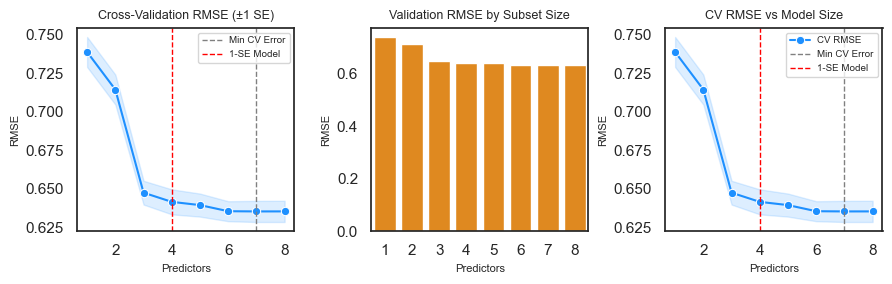

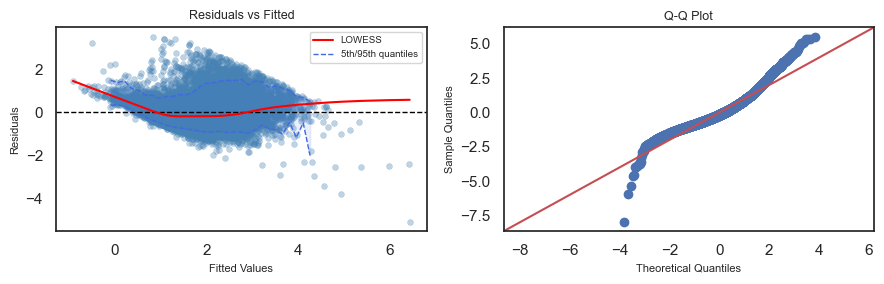

In [ ]:
features = df.drop(columns=['MedHouseVal'])
target = df['MedHouseVal']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=1998
)

kf = KFold(n_splits=5, shuffle=True, random_state=1998)
all_predictors = list(features_train.columns)
p = len(all_predictors)

subset_results = []

print(f"\n=== Exhaustive Best Subset Selection ({p} predictors total, RAW dataset) ===\n")

for k in range(1, p + 1):
    print(f"Evaluating all {len(list(itertools.combinations(all_predictors, k)))} subsets of size {k}...")
    best_rmse = np.inf
    best_subset = None
    best_std = None

    for combo in itertools.combinations(all_predictors, k):
        rmse_scores = []
        for train_idx, val_idx in kf.split(features_train):
            X_train, X_val = features_train.iloc[train_idx][list(combo)], features_train.iloc[val_idx][list(combo)]
            y_train, y_val = target_train.iloc[train_idx], target_train.iloc[val_idx]
            model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
            preds = model.predict(sm.add_constant(X_val))
            rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
        avg_rmse = np.mean(rmse_scores)
        std_err = np.std(rmse_scores) / np.sqrt(kf.get_n_splits())

        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_subset = combo
            best_std = std_err

    subset_results.append((k, best_rmse, best_std, best_subset))

cv_df = pd.DataFrame(subset_results, columns=["n_predictors", "cv_rmse", "cv_se", "subset"])

best_idx = cv_df["cv_rmse"].idxmin()
best_k = int(cv_df.loc[best_idx, "n_predictors"])
best_rmse = float(cv_df.loc[best_idx, "cv_rmse"])
best_se = float(cv_df.loc[best_idx, "cv_se"])
threshold = best_rmse + best_se
one_se_candidates = cv_df[cv_df["cv_rmse"] <= threshold]
one_se_k = int(one_se_candidates["n_predictors"].min())

print(f"\nLowest CV RMSE: {best_rmse:.4f} with {best_k} predictors.")
print(f"One-SE rule threshold: {threshold:.4f} → simplest model uses {one_se_k} predictors.\n")

chosen_k = one_se_k
best_subset = cv_df.loc[cv_df["n_predictors"] == chosen_k, "subset"].iloc[0]
print(f"=== Final Model ({chosen_k} predictors) ===")
print(f"Selected predictors: {best_subset}")
print(f"Left out: {[p for p in all_predictors if p not in best_subset]}\n")

X_train_best = sm.add_constant(features_train[list(best_subset)])
X_test_best = sm.add_constant(features_test[list(best_subset)])
final_model = sm.OLS(target_train, X_train_best).fit()
preds = final_model.predict(X_test_best)

training_r2 = final_model.rsquared
testing_r2 = r2_score(target_test, preds)
testing_rmse = np.sqrt(mean_squared_error(target_test, preds))
testing_mae = mean_absolute_error(target_test, preds)

print("=== OLS Performance (One-SE Model, RAW data) ===")
print(f"R² (train): {training_r2:.3f}")
print(f"R² (test):  {testing_r2:.3f}")
print(f"RMSE (test): {testing_rmse:.3f}")
print(f"MAE (test):  {testing_mae:.3f}")
print("\n" + "="*80)
print(final_model.summary())

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
sns.lineplot(x="n_predictors", y="cv_rmse", data=cv_df, marker="o", color="dodgerblue")
plt.fill_between(cv_df["n_predictors"], cv_df["cv_rmse"] - cv_df["cv_se"], cv_df["cv_rmse"] + cv_df["cv_se"],
                 alpha=0.15, color="dodgerblue")
plt.axvline(best_k, color="gray", linestyle="--", linewidth=1, label="Min CV Error")
plt.axvline(one_se_k, color="red", linestyle="--", linewidth=1, label="1-SE Model")
plt.title("Cross-Validation RMSE (±1 SE)", fontsize=9)
plt.xlabel("Predictors", fontsize=8)
plt.ylabel("RMSE", fontsize=8)
plt.legend(fontsize=7)

plt.subplot(1, 3, 2)
sns.barplot(x="n_predictors", y="cv_rmse", data=cv_df, color="darkorange")
plt.title("Validation RMSE by Subset Size", fontsize=9)
plt.xlabel("Predictors", fontsize=8)
plt.ylabel("RMSE", fontsize=8)

plt.subplot(1, 3, 3)
sns.lineplot(x="n_predictors", y="cv_rmse", data=cv_df, label="CV RMSE", marker="o", color="dodgerblue")
plt.fill_between(cv_df["n_predictors"], cv_df["cv_rmse"] - cv_df["cv_se"], cv_df["cv_rmse"] + cv_df["cv_se"],
                 alpha=0.15, color="dodgerblue")
plt.axvline(best_k, color="gray", linestyle="--", linewidth=1, label="Min CV Error")
plt.axvline(one_se_k, color="red", linestyle="--", linewidth=1, label="1-SE Model")
plt.title("CV RMSE vs Model Size", fontsize=9)
plt.xlabel("Predictors", fontsize=8)
plt.ylabel("RMSE", fontsize=8)
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

fitted_values = final_model.fittedvalues
model_residuals = final_model.resid
lowess_smooth = sm.nonparametric.lowess(model_residuals, fitted_values, frac=0.3)

bin_edges = np.linspace(fitted_values.min(), fitted_values.max(), 50)
bin_indices = np.digitize(fitted_values, bin_edges)
quantile_05, quantile_95, bin_centers = [], [], []
for bin_index in range(1, len(bin_edges)):
    bin_mask = bin_indices == bin_index
    if bin_mask.sum() > 10:
        quantile_05.append(np.quantile(model_residuals[bin_mask], 0.05))
        quantile_95.append(np.quantile(model_residuals[bin_mask], 0.95))
        bin_centers.append((bin_edges[bin_index-1] + bin_edges[bin_index]) / 2)

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
sns.scatterplot(x=fitted_values, y=model_residuals, color='steelblue', alpha=0.35, edgecolor=None, s=18, ax=axes[0])
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', linewidth=1.5, label='LOWESS')
axes[0].plot(bin_centers, quantile_05, color='royalblue', linestyle='--', linewidth=1, label='5th/95th quantiles')
axes[0].plot(bin_centers, quantile_95, color='royalblue', linestyle='--', linewidth=1)
axes[0].fill_between(bin_centers, quantile_05, quantile_95, color='royalblue', alpha=0.10)
axes[0].set_title("Residuals vs Fitted", fontsize=9)
axes[0].set_xlabel("Fitted Values", fontsize=8)
axes[0].set_ylabel("Residuals", fontsize=8)
axes[0].legend(fontsize=7)

sm.qqplot(model_residuals, line='45', fit=True, ax=axes[1])
axes[1].set_title("Q-Q Plot", fontsize=9)
axes[1].set_xlabel("Theoretical Quantiles", fontsize=8)
axes[1].set_ylabel("Sample Quantiles", fontsize=8)
plt.tight_layout()
plt.show()
